In [16]:
# Checking the version of Python
import sys
print(sys.version)

3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]


In [17]:
# Importing Liraries

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')


print('Libraries imported.')

Libraries imported.


# Gathering the required data

## Neighbourhood names 
The list of neighbourhoods in bangalore can be extracted from the wikipedia page<br/> 
url = 'http://bbmp.gov.in/ward-maps'

In [18]:
# Reading all the tabels from the webpage using Pandas libraray

data = pd.read_html('http://bbmp.gov.in/ward-maps')

# Converting the  required table into DataFrame

df = pd.DataFrame(data[1])
df_1 = pd.DataFrame(data[2])
df =pd.concat([df,df_1],axis = 0,ignore_index = True)

In [19]:
df.head()

,Ward No,Ward Name
0,1,Kempegowda
1,2,Chowdeshwari
2,3,Attur
3,4,Yelahanka New Town
4,5,Jakkur


In [20]:
df.tail()

,Ward No,Ward Name
193,194,Gottigere
194,195,Konanakunte
195,196,Anjanapura
196,197,Vasanthapura
197,198,Hemmigepura


In [21]:
#To drop image and summary column
df.drop(['Ward No'],axis=1,inplace = True)

In [22]:
df.rename(columns={'Ward Name': 'Neighbourhood'},inplace = True)
df.head()

,Neighbourhood
0,Kempegowda
1,Chowdeshwari
2,Attur
3,Yelahanka New Town
4,Jakkur


## Getting Latitude and Longitude of all neighborhood

I am using BeautifulSoup web scarping library to scrap google.com to get the latitude and longitude of neighborhood.

In [ ]:
# Importing Scarping Library
import time
import urllib
import requests
from bs4 import BeautifulSoup

In [ ]:
latitude_list =[]
longitude_list =[]
# desktop user-agent
USER_AGENT = "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:65.0) Gecko/20100101 Firefox/65.0"
count = 1

for index,place in enumerate(list(df['Neighbourhood'])):  
    query= "{} Bangalore India latitude and longitude".format(place)
    query = query.replace(' ', '+')
    URL = f"https://google.com/search?q={query}"  
    # desktop user-agent
    headers = {"user-agent" : USER_AGENT}
    resp = requests.get(URL, headers=headers)
    try:
    
        if resp.status_code == 200:
            soup = BeautifulSoup(resp.content, "html.parser")
            mydivs = soup.find("div",class_= "Z0LcW XcVN5d").text
            latLong = (mydivs).split(" ")
            latitude_list.append(float(latLong[0][:-1]))
            longitude_list.append(float(latLong[2][:-1]))     
    except:
        latitude_list.append("Nan")
        longitude_list.append("Nan")
    count+=1
    time.sleep(2)
print("Completed")

In [ ]:
# Converting neighborhood names with latitude and longitudes to Dataframe
df['Latitude']=latitude_list
df['Longitude']=longitude_list

In [ ]:
#To check for Nan values

print("Checking for Nan values by Latitude\n")
print(df[df["Latitude"]=="Nan"].count())

print("\nChecking for Nan values by Longitude\n")
print(df[df["Longitude"]=="Nan"].count())

In [ ]:
df[df["Latitude"]=="Nan"]

In [ ]:
# Adding the latitude and Longitude

missing_lat = [12.9716,13.0096,12.955169,12.9343,12.991629,12.8773,12.962816,12.950516,12.936756]
missing_long =[77.5678,77.2611,77.569677,77.5659,77.557536,77.5692,77.566305,77.585168,77.549743]
i = 0
for x,y in enumerate(df['Longitude']):
    if y == "Nan":
        df.iloc[x,1]=missing_lat[i]
        df.iloc[x,2]=missing_long[i]
        i+=1

In [ ]:
# saving the dataframe as a CSV file for future ref

df.to_csv('bangalore_lat_long.csv')

In [23]:
# Accesing data from the saved csv file

data= pd.read_csv('bangalore_lat_long.csv',index_col=0)
df = pd.DataFrame(data)
df.head()

,Neighbourhood,Latitude,Longitude
0,Kempegowda,12.9767,77.5713
1,Chowdeshwari,13.1049,77.5952
2,Attur,13.1070,77.5663
3,Yelahanka New Town,13.1042,77.5713
4,Jakkur,13.0631,77.6207


## Plotting the neighborhoods on Bangalore map

In [24]:
# Getting the coordinaes of Bangalore,India
# Use geopy library Model Nominatim

address = "Bangalore,Karnataka"
locator = Nominatim(user_agent="myGeocoder")
location = locator.geocode(address)


# create map of Bangalore using latitude and longitude values
map_bangalore = folium.Map(location=[location.latitude, location.longitude], zoom_start=10.5)

# add markers to map
for lat, lng, neighborhood in zip(df['Latitude'],df['Longitude'],df['Neighbourhood']):

        label = '{}'.format(str(neighborhood))
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [float(lat),float(lng)],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_bangalore)  
    
    
map_bangalore

## Using FourSquare to get the venues

In [25]:
# Define Foursquare Credentials and Version
CLIENT_ID = 'D5EIYSNTRMPI3UEYHSYZZ4B35MPON4UG4HSUM3WHRIPPHWT4' # your Foursquare ID
CLIENT_SECRET = 'WA3HMJMEPC1FWPFIULGMVMG1523KUYINENCZUQSFRBY0UY5V' # your FoursquarWA3HMJMEPC1FWPFIULGMVMG1523KUYINENCZUQSFRBY0UY5Ve Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: D5EIYSNTRMPI3UEYHSYZZ4B35MPON4UG4HSUM3WHRIPPHWT4
CLIENT_SECRET:WA3HMJMEPC1FWPFIULGMVMG1523KUYINENCZUQSFRBY0UY5V


#### Now, let's get the top 100 venues that are in the neighborhoods of neighborhoods within a radius of 1000 meters

In [26]:
# Function to retreive venues
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    LIMIT =100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
          
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            float(lat), 
            float(lng), 
            radius, 
            LIMIT)
        
        try:    
            # make the GET request
            results = requests.get(url).json()['response']['groups'][0]['items']

            # return only relevant information for each nearby venue
            venues_list.append([(
                 name, 
                 lat, 
                 lng, 
                 v['venue']['name'], 
                 v['venue']['location']['lat'], 
                 v['venue']['location']['lng'],  
                 v['venue']['categories'][0]['name']) for v in results])
        except:
                print("Information Unavailable")
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

In [ ]:
bangalore_venues = getNearbyVenues(names=df['Neighbourhood'],latitudes=df['Latitude'],longitudes=df['Longitude'])

In [ ]:
print(bangalore_venues.shape)
bangalore_venues.head()

In [ ]:
# Saving the results as CSV for futher use
bangalore_venues.to_csv("Bangalore Venues")

# Data Analysis

In [27]:
bangalore_venues = pd.read_csv("Bangalore Venues",index_col = 0)

In [28]:
# Collecting the unique names of the venue
venue_unq = bangalore_venues['Venue Category'].unique()

In [29]:
# Getting names of diffrent unique restaurant type
restaurant_unq=[]
for x in venue_unq:
    if "Restaurant" in x:
        restaurant_unq.append(x)

In [30]:
bangalore_restaurants = bangalore_venues[bangalore_venues["Venue Category"].isin(restaurant_unq) ]
bangalore_restaurants.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Kempegowda,12.9767,77.5713,Hotel Fishland,12.975569,77.578592,Seafood Restaurant
1,Kempegowda,12.9767,77.5713,Udupi Sri Krishna Bhavan,12.971563,77.574158,Indian Restaurant
2,Kempegowda,12.9767,77.5713,SGS Donne Biriyani,12.970325,77.572648,Indian Restaurant
5,Kempegowda,12.9767,77.5713,Hotel Empire,12.979648,77.574971,Indian Restaurant
7,Kempegowda,12.9767,77.5713,Hotel Annapoorna,12.979088,77.578624,Indian Restaurant


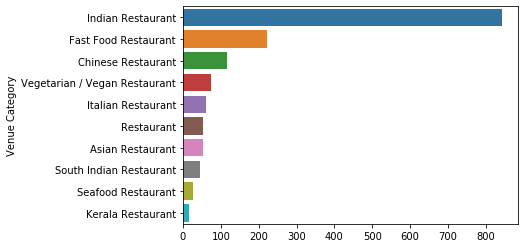

In [31]:
# Top 10 restaurants based on count
import seaborn as sns

top_10 =bangalore_restaurants.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)[:10]

ax = sns.barplot(y=top_10.index, x=top_10.values)


We can see that there are predominately large number of Indian Restaurants

In [32]:
#Searching for Dublicate values

duplicateRowsDF = df[df.duplicated()]
print("Duplicate Rows based on a single column are:", duplicateRowsDF, sep='\n')


Duplicate Rows based on a single column are:
Empty DataFrame
Columns: [Neighbourhood, Latitude, Longitude]
Index: []


## Analysing the neighbourhoods

In [33]:
# one hot encoding
bangalore_onehot = pd.get_dummies(bangalore_restaurants[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bangalore_onehot['Neighbourhood'] = bangalore_restaurants['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [bangalore_onehot.columns[-1]] + list(bangalore_onehot.columns[:-1])
bangalore_onehot = bangalore_onehot[fixed_columns]

bangalore_onehot.head()

,Neighbourhood,Afghan Restaurant,American Restaurant,Andhra Restaurant,Asian Restaurant,Bengali Restaurant,Chettinad Restaurant,Chinese Restaurant,Comfort Food Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,German Restaurant,Halal Restaurant,Hyderabadi Restaurant,Indian Chinese Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Karnataka Restaurant,Kebab Restaurant,Kerala Restaurant,Korean Restaurant,Maharashtrian Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Mughlai Restaurant,Multicuisine Indian Restaurant,New American Restaurant,North Indian Restaurant,Pakistani Restaurant,Persian Restaurant,Punjabi Restaurant,Rajasthani Restaurant,Restaurant,Seafood Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Kempegowda,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,Kempegowda,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Kempegowda,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Kempegowda,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Kempegowda,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
bangalore_onehot.shape

(1704, 53)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [35]:
bangalore_grouped = bangalore_onehot.groupby('Neighbourhood').mean().reset_index()

In [36]:
#Function to sort the venues in descending order

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [37]:
# To find the top 10 restaurants in each neighbourhood

num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = bangalore_grouped['Neighbourhood']

for ind in np.arange(bangalore_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bangalore_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,A. Narayanapura,Indian Restaurant,Fast Food Restaurant,Asian Restaurant,French Restaurant,Kerala Restaurant,Kebab Restaurant,Karnataka Restaurant,Japanese Restaurant,Italian Restaurant,Indian Chinese Restaurant
1,Adugodi,Indian Restaurant,Kerala Restaurant,Punjabi Restaurant,Tibetan Restaurant,Eastern European Restaurant,Kebab Restaurant,Karnataka Restaurant,Japanese Restaurant,Italian Restaurant,Indian Chinese Restaurant
2,Agaram,Indian Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Kerala Restaurant,Kebab Restaurant,Karnataka Restaurant,Japanese Restaurant,Italian Restaurant,Indian Chinese Restaurant,Hyderabadi Restaurant
3,Agrahara Dasarahalli,Indian Restaurant,Fast Food Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,French Restaurant,Kerala Restaurant,Kebab Restaurant,Karnataka Restaurant,Japanese Restaurant,Italian Restaurant
4,Arakere,Indian Restaurant,Chinese Restaurant,Fast Food Restaurant,South Indian Restaurant,Vietnamese Restaurant,Kebab Restaurant,Karnataka Restaurant,Japanese Restaurant,Italian Restaurant,Indian Chinese Restaurant


# Clustering of neighborhood

### Finding the best value of K using Silhouette_score

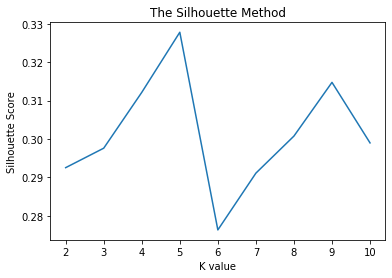

The Optimum value of K is 5


In [38]:
from sklearn.metrics import silhouette_score

X= bangalore_grouped.drop('Neighbourhood', 1)
sil = []
kmax = 10
x=range(2,kmax+1)
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k,random_state =3).fit(X)
  labels = kmeans.labels_
  sil.append(silhouette_score(X, labels, metric = 'euclidean'))
plt.plot(x,sil)
plt.title('The Silhouette Method')
plt.xlabel('K value')
plt.ylabel('Silhouette Score')
plt.show()
print("The Optimum value of K is 5")

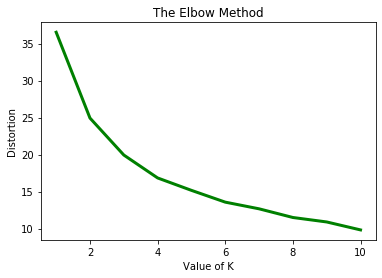

The Optimum value of K is 5


In [39]:
distortion=[]

for i in range(1, 11): 
    KM = KMeans(n_clusters = i, max_iter = 500) 
    KM.fit(X) 
      
    # calculates squared error 
    # for the clustered points 
    distortion.append(KM.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 11), distortion, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Distortion")
plt.title('The Elbow Method')
plt.show() # clear the plot 
print("The Optimum value of K is 5")

In [40]:
# set number of clusters
kclusters =5

bangalore_grouped_clustering = bangalore_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bangalore_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 1, 0, 0, 0, 3, 1, 4, 0])

In [41]:
# add clustering labels

neighbourhoods_venues_sorted.insert(0,'Cluster Labels',kmeans.labels_)

In [42]:
neighbourhoods_venues_sorted['Cluster Labels'].value_counts()

0    84
1    43
3    25
4    18
2     7
Name: Cluster Labels, dtype: int64

In [43]:
neighbourhoods_venues_sorted.head()

,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,A. Narayanapura,Indian Restaurant,Fast Food Restaurant,Asian Restaurant,French Restaurant,Kerala Restaurant,Kebab Restaurant,Karnataka Restaurant,Japanese Restaurant,Italian Restaurant,Indian Chinese Restaurant
1,0,Adugodi,Indian Restaurant,Kerala Restaurant,Punjabi Restaurant,Tibetan Restaurant,Eastern European Restaurant,Kebab Restaurant,Karnataka Restaurant,Japanese Restaurant,Italian Restaurant,Indian Chinese Restaurant
2,1,Agaram,Indian Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Kerala Restaurant,Kebab Restaurant,Karnataka Restaurant,Japanese Restaurant,Italian Restaurant,Indian Chinese Restaurant,Hyderabadi Restaurant
3,0,Agrahara Dasarahalli,Indian Restaurant,Fast Food Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,French Restaurant,Kerala Restaurant,Kebab Restaurant,Karnataka Restaurant,Japanese Restaurant,Italian Restaurant
4,0,Arakere,Indian Restaurant,Chinese Restaurant,Fast Food Restaurant,South Indian Restaurant,Vietnamese Restaurant,Kebab Restaurant,Karnataka Restaurant,Japanese Restaurant,Italian Restaurant,Indian Chinese Restaurant


In [44]:
bangalore_merged =df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
bangalore_merged = bangalore_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')


In [45]:
bangalore_merged[bangalore_merged.isin([np.nan, np.inf, -np.inf]).any(1)]

,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Kodigehalli,13.0697,77.5788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,Dasarahalli,13.0580,77.6049,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,Radhakrishna Temple,13.0225,77.5325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,Doddabidarakallu,13.0333,77.4906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,Peenya Industrial Area,13.0285,77.5197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,Lakshmidevinagar,13.0141,77.5268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,Nandini Layout,13.0137,77.5339,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,Vijanapura,13.0025,77.6747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,Hegganahalli,13.0064,77.5171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,Herohalli,12.9897,77.4896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
# Dropping the rows with Nan value
bangalore_merged.dropna(inplace= True)

In [47]:
conv_dic={'Latitude': float,
         'Longitude': float,
         'Cluster Labels': int}

bangalore_merged = bangalore_merged.astype(conv_dic)

# Mapping Clusters

In [48]:
# create map
map_clusters =  folium.Map(location=[location.latitude, location.longitude], zoom_start=10.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bangalore_merged['Latitude'], bangalore_merged['Longitude'], bangalore_merged['Neighbourhood'],bangalore_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [float(lat), float(lon)],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#  Examining the Clusters

In [49]:
# Importing libraires for WordCloud

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [50]:
bangalore = bangalore_merged
bangalore =bangalore.drop(['Latitude','Longitude'],1)

In [51]:
# Function to examine the cluster with the help of word cloud


def wordcloud_(i):
    text=[]
    for x in range(bangalore.shape[0]):
        if(bangalore.iloc[x,1]== i):
            for y in range(2,11):
                text_list_weighted =((((bangalore.iloc[x,y]).replace(" ","_"))+(" "))*(11-y)).split(" ")
                for element in text_list_weighted[:-1]:
                    text.append(element)
    text =','.join(text)
    
    # Create and generate a word cloud image:
    wordcloud = WordCloud(width=1600, height=800,background_color='white').generate(text)

    # Display the generated image:
   
# Open a plot of the generated image.

    plt.figure( figsize=(20,10), facecolor='k')
    plt.tight_layout(pad=0)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()


## Cluster 0

In [52]:
bangalore[bangalore["Cluster Labels"]== 0].head()

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Byatarayanapura,0,Indian Restaurant,Chinese Restaurant,Fast Food Restaurant,Italian Restaurant,French Restaurant,Kerala Restaurant,Kebab Restaurant,Karnataka Restaurant,Japanese Restaurant,Indian Chinese Restaurant
10,Kuvempunagar,0,Indian Restaurant,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Chinese Restaurant,Italian Restaurant,South Indian Restaurant,Dim Sum Restaurant,Restaurant,Comfort Food Restaurant,Halal Restaurant
15,Jalahalli,0,Indian Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Italian Restaurant,Kerala Restaurant,Kebab Restaurant,Karnataka Restaurant,Japanese Restaurant,Indian Chinese Restaurant,Hyderabadi Restaurant
16,J P Park,0,Indian Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Kerala Restaurant,Kebab Restaurant,Karnataka Restaurant,Japanese Restaurant,Italian Restaurant,Indian Chinese Restaurant,Hyderabadi Restaurant
19,Ganganagar,0,Indian Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Kerala Restaurant,Kebab Restaurant,Karnataka Restaurant,Japanese Restaurant,Italian Restaurant,Indian Chinese Restaurant,Hyderabadi Restaurant


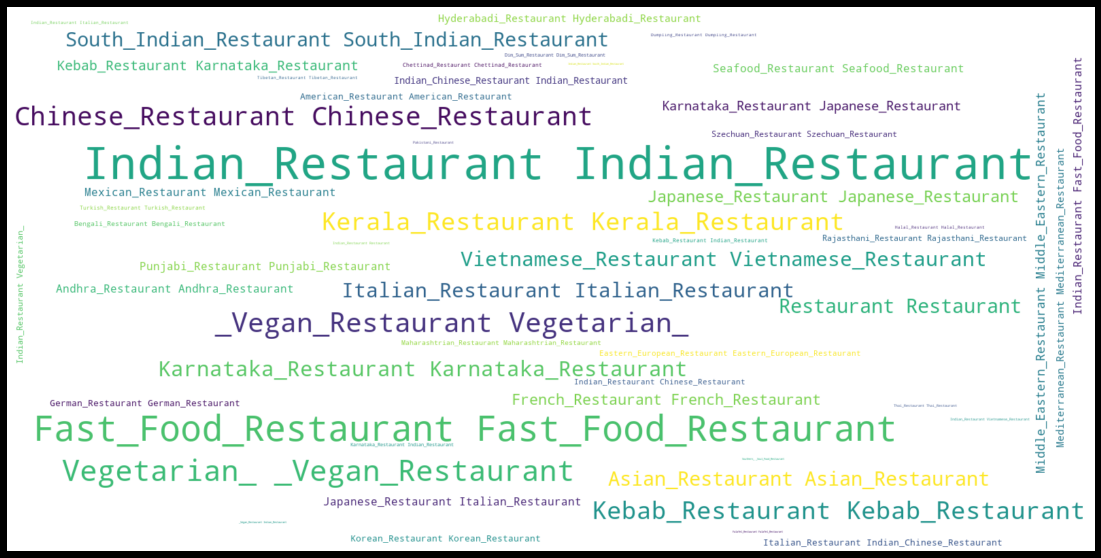

In [53]:
wordcloud_(0)

From the wordcloud we can infer that the neighbour hood under **cluster 0** has more number of ***Indian and Fast Food Restaurants*** followed by ***Kerala Restaurant***

## Cluster 1

In [54]:
bangalore[bangalore["Cluster Labels"]== 1].head()

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Kempegowda,1,Indian Restaurant,Restaurant,Seafood Restaurant,Fast Food Restaurant,Falafel Restaurant,Kebab Restaurant,Karnataka Restaurant,Japanese Restaurant,Italian Restaurant,Indian Chinese Restaurant
2,Attur,1,Indian Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Kerala Restaurant,Kebab Restaurant,Karnataka Restaurant,Japanese Restaurant,Italian Restaurant,Indian Chinese Restaurant,Hyderabadi Restaurant
3,Yelahanka New Town,1,Indian Restaurant,Andhra Restaurant,Vietnamese Restaurant,French Restaurant,Kerala Restaurant,Kebab Restaurant,Karnataka Restaurant,Japanese Restaurant,Italian Restaurant,Indian Chinese Restaurant
5,Thanisandra,1,Indian Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Kerala Restaurant,Kebab Restaurant,Karnataka Restaurant,Japanese Restaurant,Italian Restaurant,Indian Chinese Restaurant,Hyderabadi Restaurant
8,Vidyaranyapura,1,Indian Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Kerala Restaurant,Kebab Restaurant,Karnataka Restaurant,Japanese Restaurant,Italian Restaurant,Indian Chinese Restaurant,Hyderabadi Restaurant


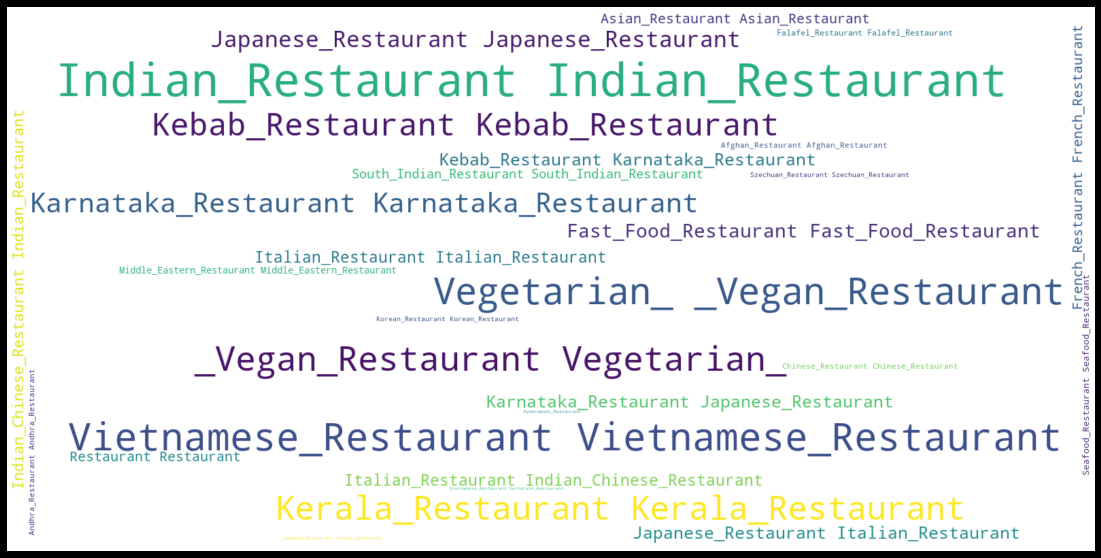

In [55]:
wordcloud_(1)

From the wordcloud we can infer that the neighbour hood under **cluster 1** has more number of ***Indian Restaurant*** and ***Vietnamese Restaurant***

## Cluster 2

In [56]:
bangalore[bangalore["Cluster Labels"]== 2].head()

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
31,Kaval Byrasandra,2,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Kerala Restaurant,Kebab Restaurant,Karnataka Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant,Indian Chinese Restaurant,Hyderabadi Restaurant
69,Rajagopalanagar,2,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Kerala Restaurant,Kebab Restaurant,Karnataka Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant,Indian Chinese Restaurant,Hyderabadi Restaurant
81,Garudacharpalya,2,Fast Food Restaurant,Asian Restaurant,French Restaurant,Kerala Restaurant,Kebab Restaurant,Karnataka Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant,Indian Chinese Restaurant
114,Vannarpet,2,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Kerala Restaurant,Kebab Restaurant,Karnataka Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant,Indian Chinese Restaurant,Hyderabadi Restaurant
120,Binnypet,2,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Kerala Restaurant,Kebab Restaurant,Karnataka Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant,Indian Chinese Restaurant,Hyderabadi Restaurant


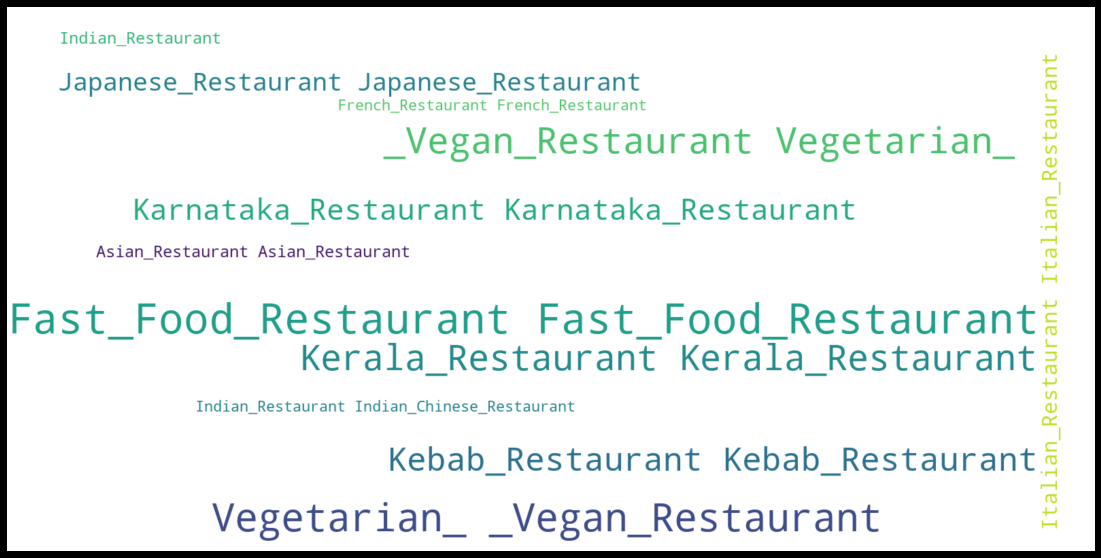

In [57]:
wordcloud_(2)

From the wordcloud we can infer that the neighbour hood under **cluster 2** has more number of ***Fast Food Restaurants*** followed by ***Vegan/Vegetarain Restaurant*** and ***Kerala_Restaurant***

## Cluster 3

In [58]:
bangalore[bangalore["Cluster Labels"]== 3].head()

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Chowdeshwari,3,Fast Food Restaurant,American Restaurant,Chinese Restaurant,Vegetarian / Vegan Restaurant,German Restaurant,Kerala Restaurant,Kebab Restaurant,Karnataka Restaurant,Japanese Restaurant,Italian Restaurant
4,Jakkur,3,South Indian Restaurant,Vietnamese Restaurant,Fast Food Restaurant,Kebab Restaurant,Karnataka Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant,Indian Chinese Restaurant,Hyderabadi Restaurant
27,Kammanahalli,3,Indian Restaurant,Fast Food Restaurant,Korean Restaurant,Chinese Restaurant,Restaurant,South Indian Restaurant,Kerala Restaurant,Vegetarian / Vegan Restaurant,Karnataka Restaurant,Italian Restaurant
28,Kacharakanahalli,3,Indian Restaurant,Fast Food Restaurant,Kerala Restaurant,South Indian Restaurant,Chinese Restaurant,Falafel Restaurant,Korean Restaurant,Restaurant,Andhra Restaurant,Comfort Food Restaurant
36,Yeshwanthpura,3,Fast Food Restaurant,Mediterranean Restaurant,Indian Restaurant,Chinese Restaurant,Seafood Restaurant,Restaurant,Punjabi Restaurant,Vietnamese Restaurant,Karnataka Restaurant,Japanese Restaurant


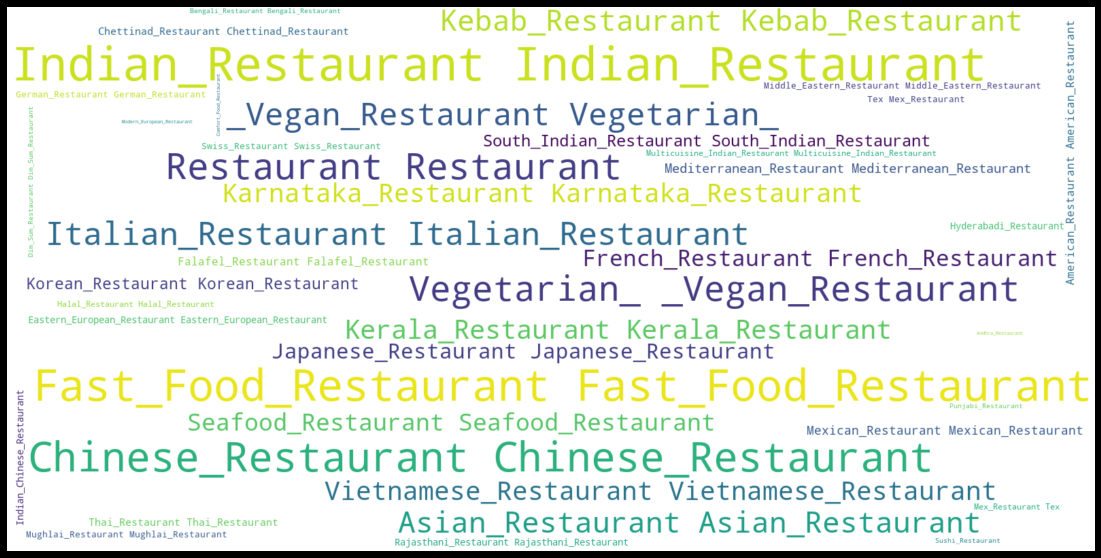

In [59]:
wordcloud_(3)

From the wordcloud we can infer that the neighbourhood under **cluster 3** has more types of restaurant ,then any other cluster. The neighbourhood falling under this cluster mainly a part of city centre.

## Cluster 4

In [60]:
bangalore[bangalore["Cluster Labels"]== 4].head()

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Sanjay Nagar,4,Fast Food Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Kerala Restaurant,Kebab Restaurant,Karnataka Restaurant,Japanese Restaurant,Italian Restaurant,Indian Chinese Restaurant,Hyderabadi Restaurant
30,Kushal Nagar,4,Fast Food Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Kerala Restaurant,Kebab Restaurant,Karnataka Restaurant,Japanese Restaurant,Italian Restaurant,Indian Chinese Restaurant,Hyderabadi Restaurant
32,Manorayana Palya,4,Fast Food Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Kerala Restaurant,Kebab Restaurant,Karnataka Restaurant,Japanese Restaurant,Italian Restaurant,Indian Chinese Restaurant,Hyderabadi Restaurant
38,Chokkasandra,4,Fast Food Restaurant,Karnataka Restaurant,Vegetarian / Vegan Restaurant,Kerala Restaurant,Kebab Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant,Indian Chinese Restaurant,Hyderabadi Restaurant
43,Marappana Palya,4,Fast Food Restaurant,Asian Restaurant,Indian Restaurant,French Restaurant,Kerala Restaurant,Kebab Restaurant,Karnataka Restaurant,Japanese Restaurant,Italian Restaurant,Indian Chinese Restaurant


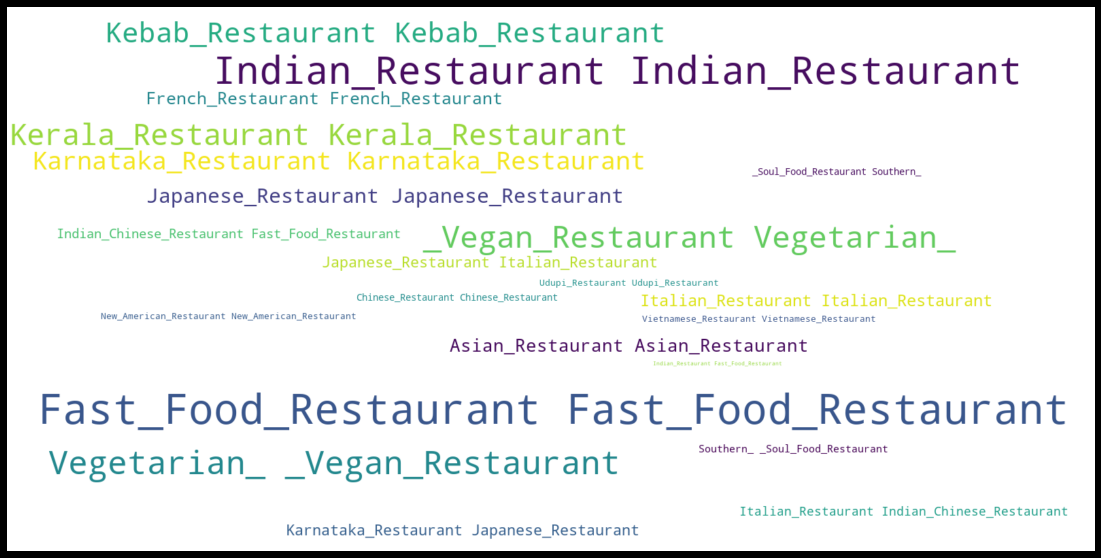

In [61]:
wordcloud_(4)

From the wordcloud we can infer that the neighbour hood under cluster 3 has more number of ***Indian Restaurants*** followed by ***Fast Food Restaurant*** and ***Kebab Restaurant***

# Conclusion

The best place to open an **Mexican Restaurant** could be one the places that falls under **cluster 3** as there are no hotels that severe mexican foods in those neighborhood.

In [62]:
suggested_neighborhood = bangalore[bangalore["Cluster Labels"]== 2]

In [63]:
 list(suggested_neighborhood["Neighbourhood"])

['Kaval Byrasandra',
 'Rajagopalanagar',
 'Garudacharpalya',
 'Vannarpet',
 'Binnypet',
 'Srinagara',
 'Girinagara']

### Best suited neighbourhoods for Tacolicious 
    1.Kaval Byrasandar
    2.Rajagopalanagar
    3.Garudacharpalya
    4.Vannarpet
    5.Binnypet
    6.Srinagara
    7.Girinagara